In [10]:
# All imports 
import random
import math 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

random.seed(2025)

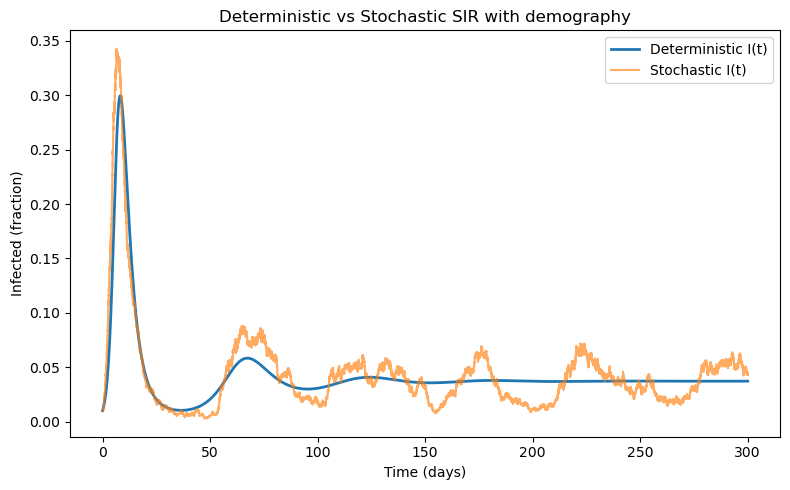

In [ ]:
# Implement Gillespies (Direct) Algorithm 


def gillespie_sir(X0, Y0, Z0, beta, gamma, mu, nu, T_max):
    """Gillespie (direct method) for SIR with demography; returns times and X,Y,Z lists."""
    
    X, Y, Z = X0, Y0, Z0
    t = 0.0

    times = [t]
    X_list, Y_list, Z_list = [X], [Y], [Z]

    # step 1: label all possible events 
    events = {
    "birth":     (+1,  0,  0),  
    "infection": (-1, +1,  0),   
    "recovery":  ( 0, -1, +1),  
    "death_S":   (-1,  0,  0),   
    "death_I":   ( 0, -1,  0),   
    "death_R":   ( 0,  0, -1),   
}

    while True:
        N = X + Y + Z

        # step 2: define event rates R_m
        birth_rate      = nu * N
        infection_rate  = beta * X * Y / N if N > 0 else 0.0
        recovery_rate   = gamma * Y
        deathS_rate     = mu * X
        deathI_rate     = mu * Y
        deathR_rate     = mu * Z

        rates = [birth_rate, infection_rate, recovery_rate,
                 deathS_rate, deathI_rate, deathR_rate]
        names = ["birth", "infection", "recovery", "death_S", "death_I", "death_R"]

        # step 3: calculate the total rate
        R_total = sum(rates)
        if R_total <= 0.0:
            break  

        # step 4: set time until next event
        u1 = random.random()
        dt = -math.log(u1) / R_total

        # step 5: draw second random number and set P
        u2 = random.random()
        P = u2 * R_total

        # step 6: choose event p by cumulative rates an apply it 
        cumulative = 0.0
        event = None
        for k, r in enumerate(rates):
            cumulative += r
            if P <= cumulative:
                event = names[k]
                break

        # step 7; update time and states 
        dX, dY, dZ = events[event]
        X += dX; Y += dY; Z += dZ

        t += dt
        times.append(t)
        X_list.append(X)
        Y_list.append(Y)
        Z_list.append(Z)

        # step 8: return to step 2
        if t >= T_max:
            break
        if Y == 0 and infection_rate == 0.0:
            break

    return times, X_list, Y_list, Z_list

# Deterministic SIR
def sir_ode(y, t, beta, gamma, mu, nu):
    S, I, R = y
    dSdt = nu - beta*S*I - mu*S
    dIdt = beta*S*I - (gamma + mu)*I
    dRdt = gamma*I - mu*R
    return [dSdt, dIdt, dRdt]

# Compare stochastic vs deterministic 
beta = 1
gamma = 1 / 3
mu = nu = 1 / 50
T_max = 300

N0 = 1000
X0, Y0, Z0 = 990, 10, 0
y0 = [X0/N0, Y0/N0, Z0/N0]

# deterministic
t_det = np.linspace(0, T_max, 1000)
sol = odeint(sir_ode, y0, t_det, args=(beta, gamma, mu, nu))
S_det, I_det, R_det = sol.T

# stochastic
t_sto, X_sto, Y_sto, Z_sto = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, nu, T_max)

# convert counts into fractions for comparison 
I_sto_frac = [i/(x+i+z) for x, i, z in zip(X_sto, Y_sto, Z_sto)]

# plot I(t)
plt.figure(figsize=(8,5))
plt.plot(t_det, I_det, lw=2, label='Deterministic I(t)')
plt.step(t_sto, I_sto_frac, where='post', alpha=0.65, label='Stochastic I(t)')
plt.xlabel('Time (days)'); plt.ylabel('Infected (fraction)')
plt.title('Deterministic vs Stochastic SIR with demography')
plt.legend(); plt.tight_layout(); plt.show()




In [15]:
# Investigate Simulation Variability and Negative Co-variance
def run_gillespie(initial_state, beta, gamma, mu, nu, t_max, n_runs):
    X, Y, Z = initial_state
    
    # common time grid
    grid = np.arange(0, t_max + 0.5, 0.5)
    all_trajectories = np.zeros((n_runs, len(grid), 3))

    # results = np.zeros(N, )
    for i in range(n_runs):
        t_list, X_list, Y_list, Z_list = gillespie_sir(X, Y, Z, beta, gamma, mu, nu, t_max)
        
        # indices of last event time <= each grid time
        idx = np.searchsorted(np.asarray(t_list), grid, side='right') - 1
        
        # if first event happens after t = 0.5
        idx = np.clip(idx, 0, len(t_list)-1)  

        X_grid = np.asarray(X_list)[idx]
        Y_grid = np.asarray(Y_list)[idx]
        Z_grid = np.asarray(Z_list)[idx]
        
        all_trajectories[i, :, 0] = X_grid
        all_trajectories[i, :, 1] = Y_grid 
        all_trajectories[i, :, 2] = Z_grid 
        
        
    return grid, all_trajectories


In [16]:
def summary_stats(t_grid, all_trajectories):
    X = all_trajectories[:,:,0]
    Y = all_trajectories[:,:,1]
    Z = all_trajectories[:,:,2]
    N = X + Y + Z

    # normalize to fractions for better comparison ODE
    s = X / N
    i = Y / N
    r = Z / N

    # means
    st_mean = np.mean(s, axis=0)
    it_mean = np.mean(i, axis=0)
    rt_mean = np.mean(r, axis=0)

    # sample variance
    s_var = s.var(axis=0, ddof=1)
    i_var = i.var(axis=0, ddof=1)
    r_var = r.var(axis=0, ddof=1)

    # covariance
    si_cov = np.array([np.cov(s[:, j], i[:, j], ddof=1)[0, 1] for j in range(s.shape[1])])
    
    return {'t': t_grid, 's_mean': st_mean, 'i_mean': it_mean, 'r_mean': rt_mean,
            's_var': s_var, 'i_var': i_var, 'r_var': r_var, 'si_cov': si_cov}





In [ ]:
def parameter_sweep(parameter, values, initial_state, T_max, n_runs):
   
    results = {}

    for val in values:
        params = {
        "beta": 1,
        "gamma": 1/3,
        "mu" : 1/50,
        "nu" : 1/50,
        "N" : 1000
        }

        X, Y, Z = initial_state
        params[parameter] = val
        
        if parameter == "N":
            X = 0.99 * val
            Y = 0.01 * val
        
        if parameter == "mu":
            params['nu'] = val
        
        grid, all_traj = run_gillespie(
            initial_state=(X, Y, Z),
            beta=params["beta"],
            gamma=params["gamma"],
            mu=params["mu"],
            nu=params["nu"],
            t_max=T_max,
            n_runs=n_runs,
        )
        stats = summary_stats(grid, all_traj)

        N = X + Y + Z
        y0 = np.array([X/N, Y/N, Z/N])
        t_ode = np.linspace(0, T_max, 1000)
        solved = odeint(sir_ode, y0, t_ode, args=(params["beta"], params["gamma"], params["mu"], params["nu"]))
        S_det, I_det, R_det = solved.T  

        results[val] = {
            "params": params,
            "init_state": (X, Y, Z),
            "grid": grid,                   
            "traj": all_traj,               
            "stats": stats,                 
            "ode_t": t_ode,                 
            "ode_SIR": (S_det, I_det, R_det)  
        }
    return results
        

        


In [ ]:
beta_sweep = parameter_sweep(
    parameter="beta",
    values=[0.5, 1.0, 10],
    initial_state=(990, 10, 0),
    T_max=150,
    n_runs=300
)


In [60]:
N_sweep = parameter_sweep(
    parameter="N",
    values=[100, 1000, 10000, 100000],      
    initial_state=(990, 10, 0),
    T_max=150,
    n_runs=300
)

In [96]:
mu_sweep = parameter_sweep(
    parameter="mu",
    values=[1/500, 1/50, 1/20, 1/10],      
    initial_state=(990, 10, 0),
    T_max=150,
    n_runs=300
)

In [92]:
def plot_sweep(parameter_name, title, results):
    vals = results.keys()
    fig, axes = plt.subplots(2, 1, dpi=300, figsize=(6,8),sharex=True)
    colors = ["lightcoral", "limegreen", "lightskyblue", "fuchsia"]
    for c, val in enumerate(vals):
        item = results[val]
        t = item["grid"]
        i_sto = item["stats"]["i_mean"]
        i_sd = np.sqrt(item["stats"]["i_var"])
        si_cov = item["stats"]["si_cov"]

        t_ode = item["ode_t"]
        i_ode = item["ode_SIR"][1]
        
        axes[0].plot(t, i_sto, label=f"{parameter_name}: {val}", lw=0.8, color=colors[c])
        axes[0].plot(t_ode, i_ode, ls='--', lw=0.5, color=colors[c])
        axes[0].fill_between(t, i_sto - i_sd, i_sto + i_sd, alpha=0.15, linewidth=0, color=colors[c])

        axes[1].plot(t, si_cov, lw=1, label=f"{parameter_name}: {val}", color=colors[c])
    
    axes[0].set_title("Mean infected fraction vs ODE")
    axes[0].set_xlabel("time"); axes[0].set_ylabel("infected fraction")
    axes[0].grid(alpha=0.3)
    axes[0].plot([], [], ls='--', color='k', label='Deterministic')
    axes[0].legend(frameon=False)

    axes[1].set_title(r" Covariance of fractions  $\mathrm{Cov}(s,i)(t)$")
    axes[1].set_xlabel("time"); axes[1].set_ylabel(r"$\mathrm{Cov}(s,i)$")
    axes[1].axhline(0, color='k', lw=1, alpha=0.4)
    axes[1].grid(alpha=0.3)
    axes[1].legend(frameon=False, fontsize=9)

    fig.suptitle(title, y=1.02, fontsize=13)
    fig.tight_layout()
    return fig, axes

(<Figure size 1800x2400 with 2 Axes>,
 array([<Axes: title={'center': 'Mean infected fraction vs ODE'}, xlabel='time', ylabel='infected fraction'>,
        <Axes: title={'center': ' Covariance of fractions  $\\mathrm{Cov}(s,i)(t)$'}, xlabel='time', ylabel='$\\mathrm{Cov}(s,i)$'>],
       dtype=object))

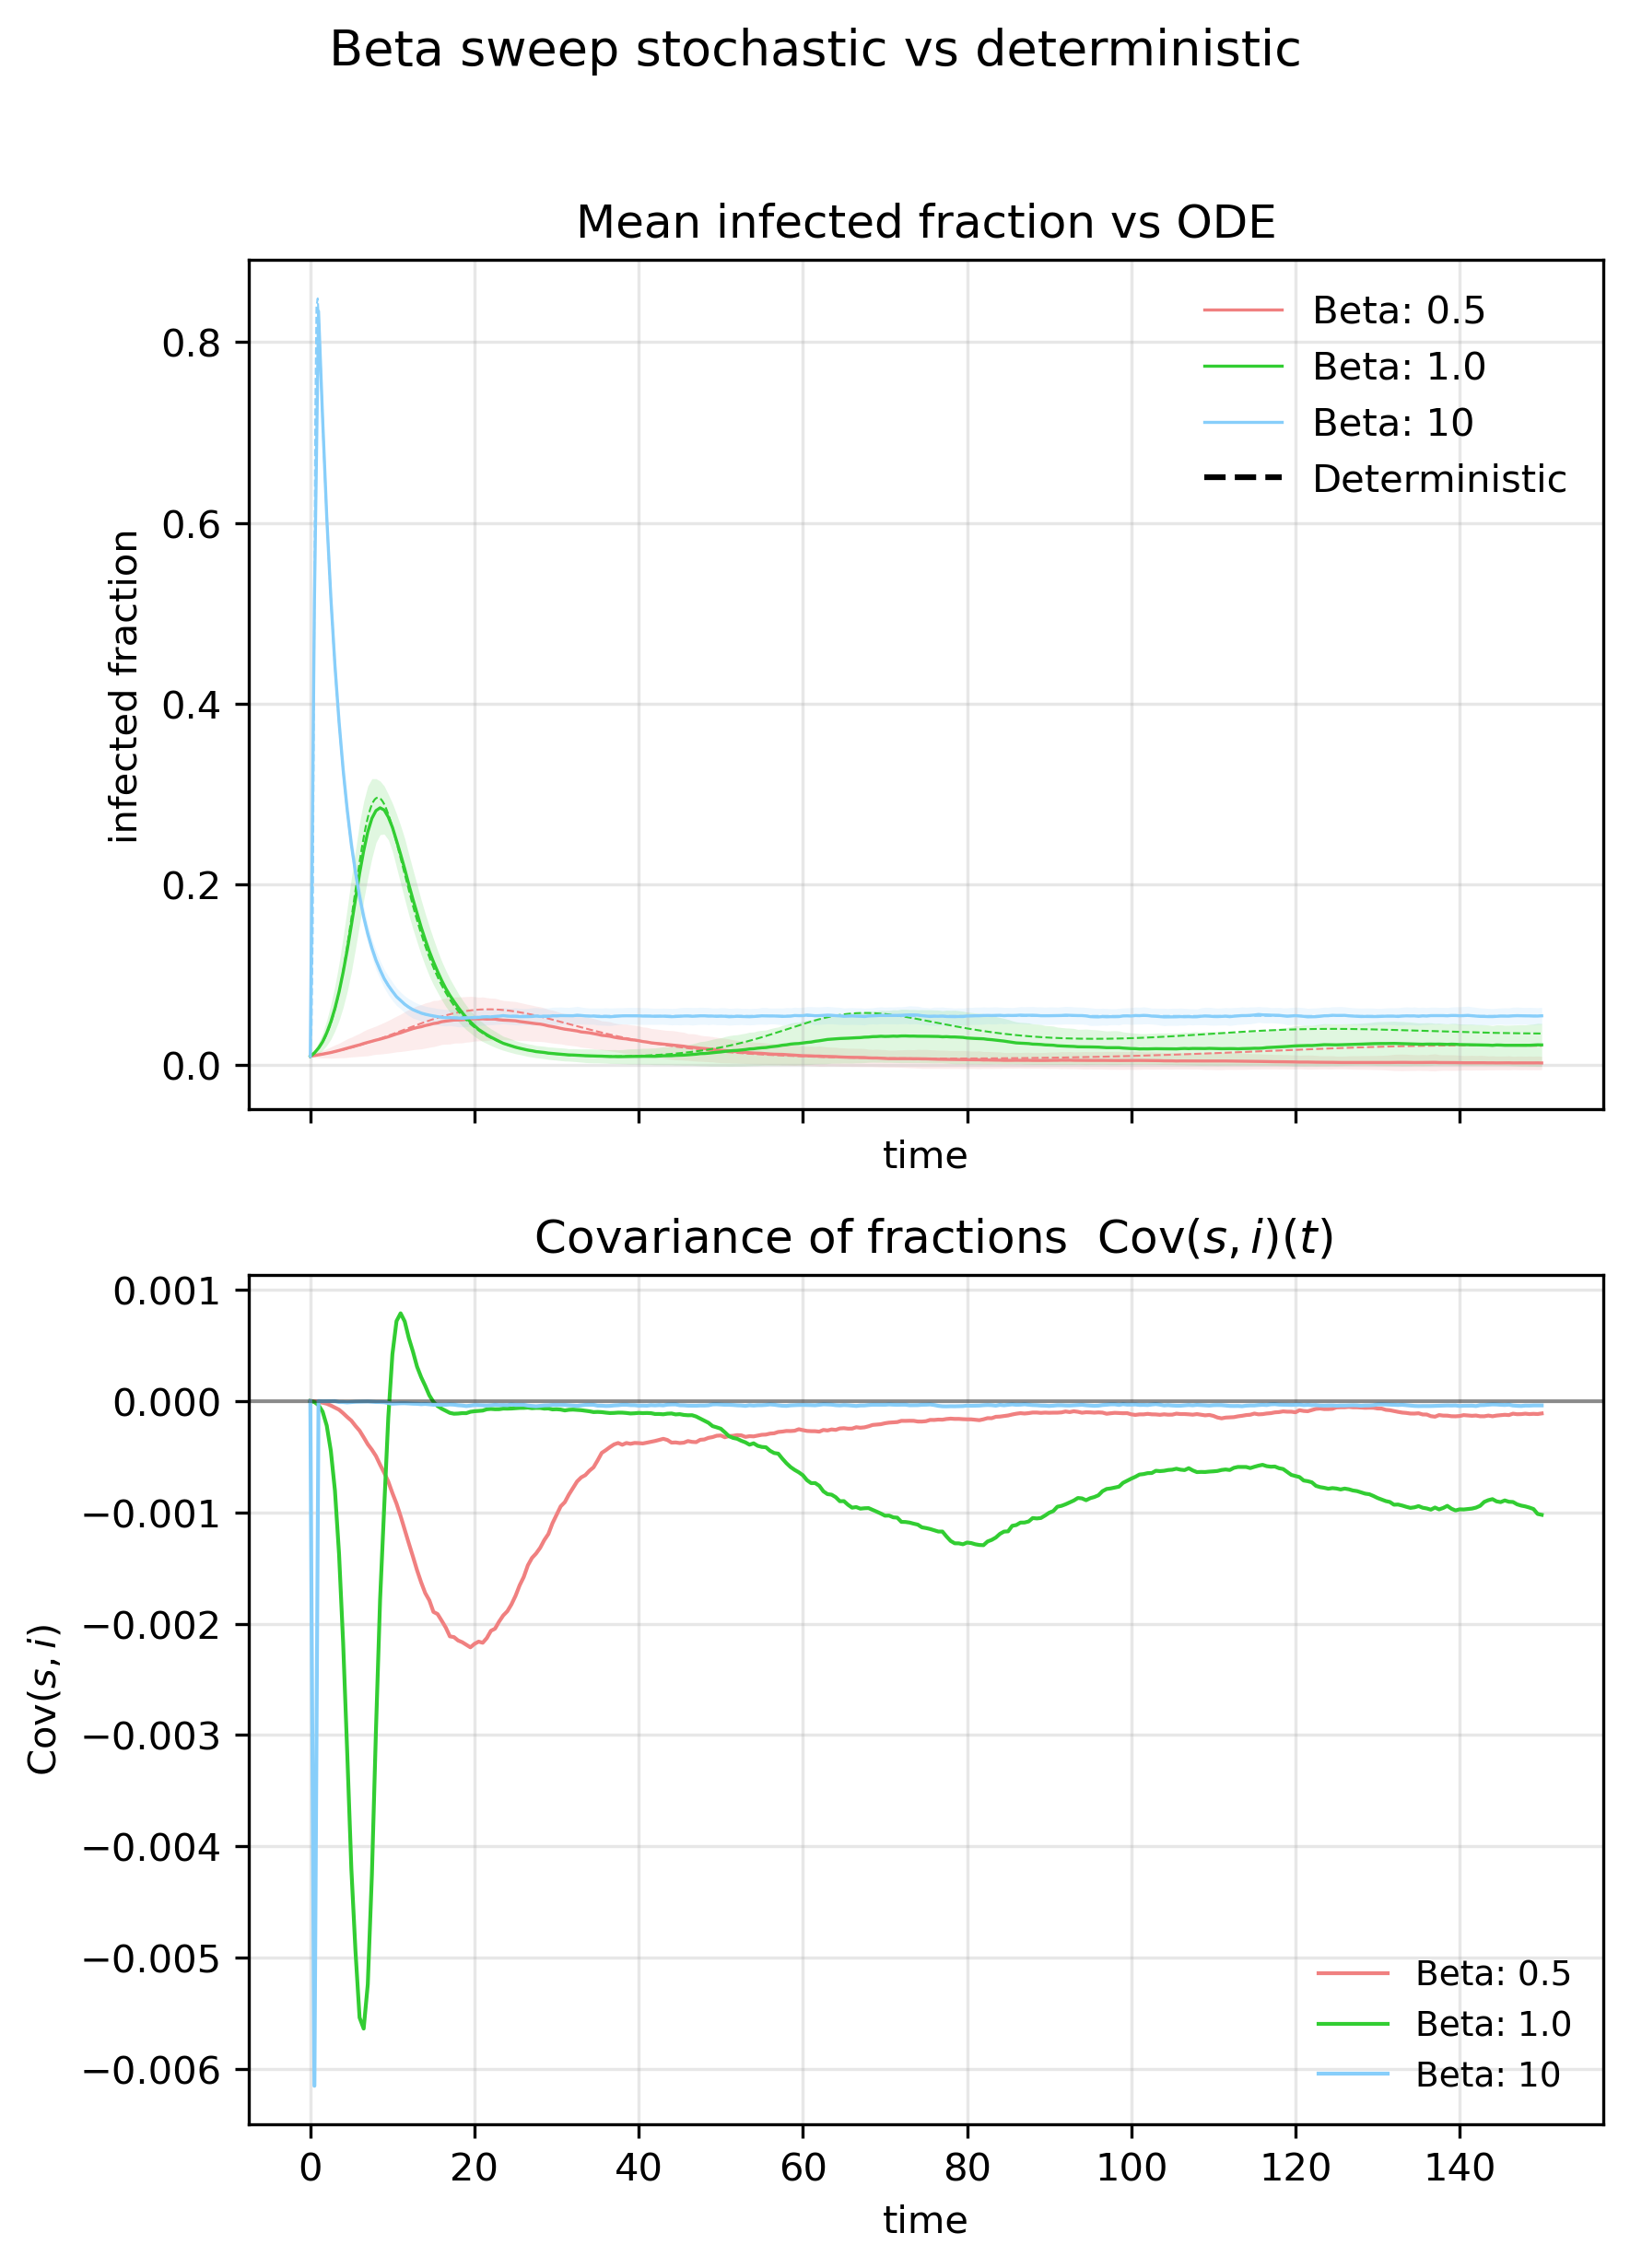

In [93]:
plot_sweep("Beta", "Beta sweep stochastic vs deterministic", beta_sweep)

(<Figure size 1800x2400 with 2 Axes>,
 array([<Axes: title={'center': 'Mean infected fraction vs ODE'}, xlabel='time', ylabel='infected fraction'>,
        <Axes: title={'center': ' Covariance of fractions  $\\mathrm{Cov}(s,i)(t)$'}, xlabel='time', ylabel='$\\mathrm{Cov}(s,i)$'>],
       dtype=object))

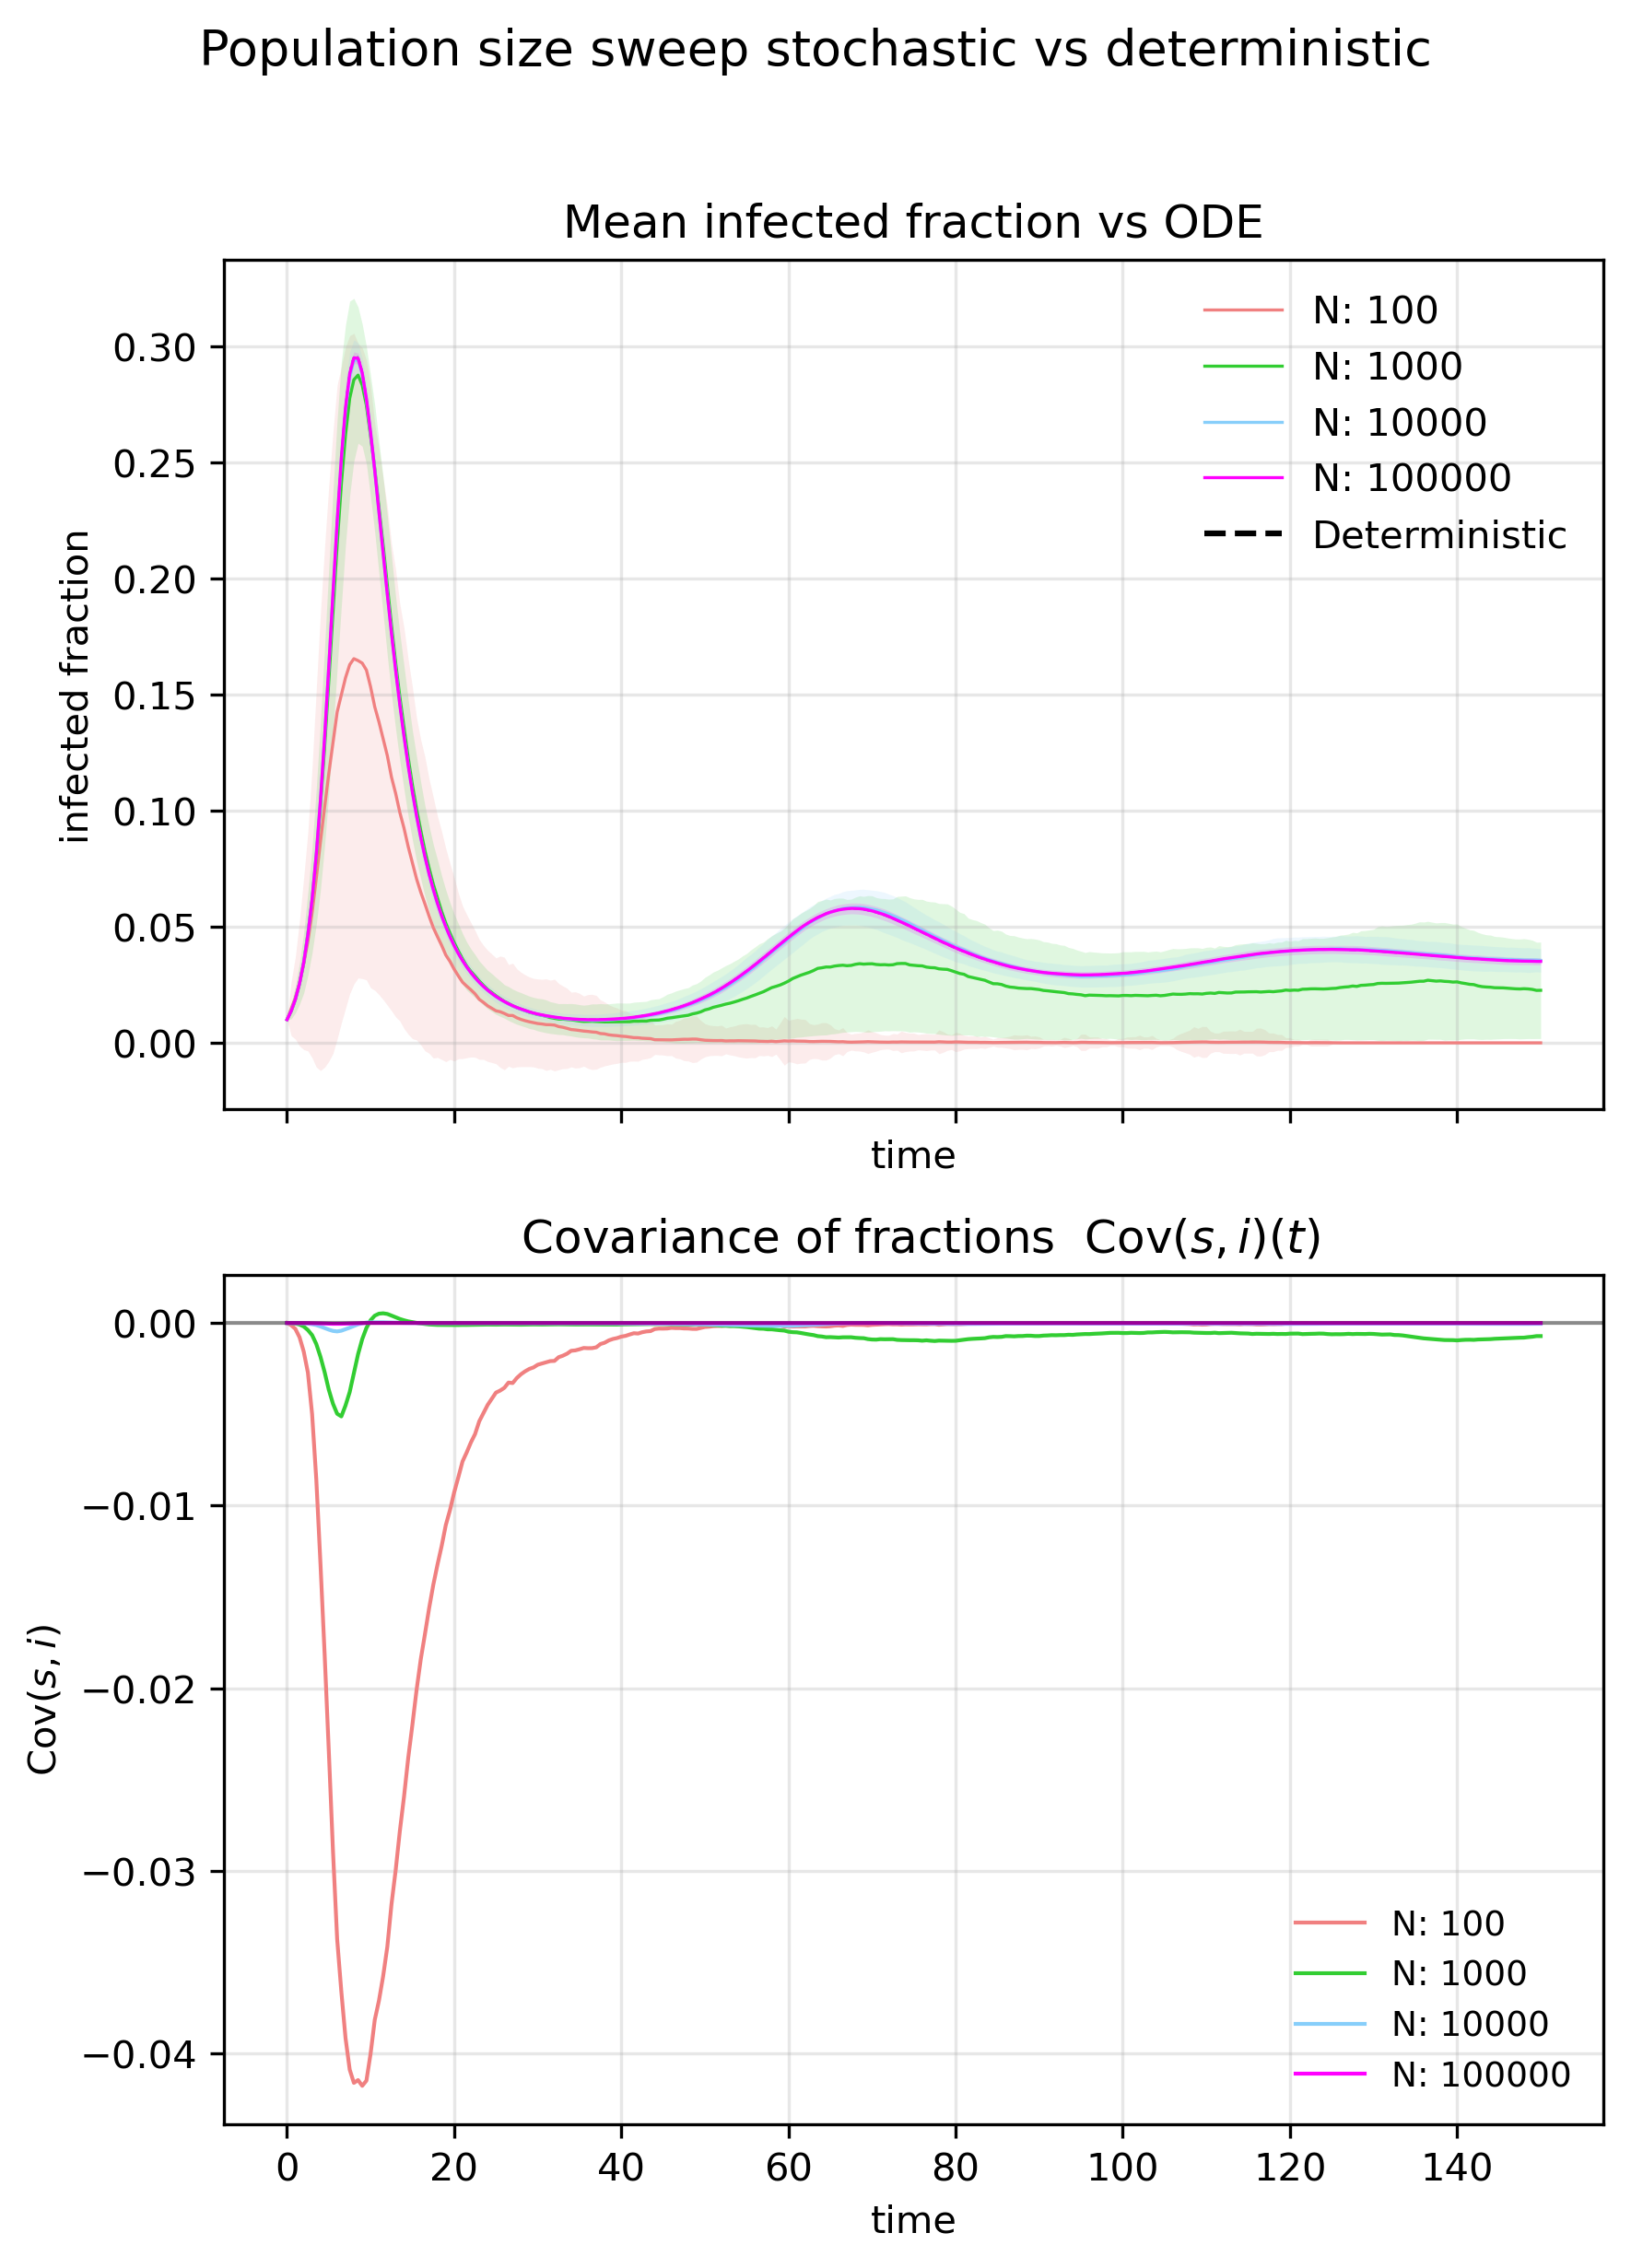

In [94]:
plot_sweep("N", "Population size sweep stochastic vs deterministic", N_sweep)

(<Figure size 1800x2400 with 2 Axes>,
 array([<Axes: title={'center': 'Mean infected fraction vs ODE'}, xlabel='time', ylabel='infected fraction'>,
        <Axes: title={'center': ' Covariance of fractions  $\\mathrm{Cov}(s,i)(t)$'}, xlabel='time', ylabel='$\\mathrm{Cov}(s,i)$'>],
       dtype=object))

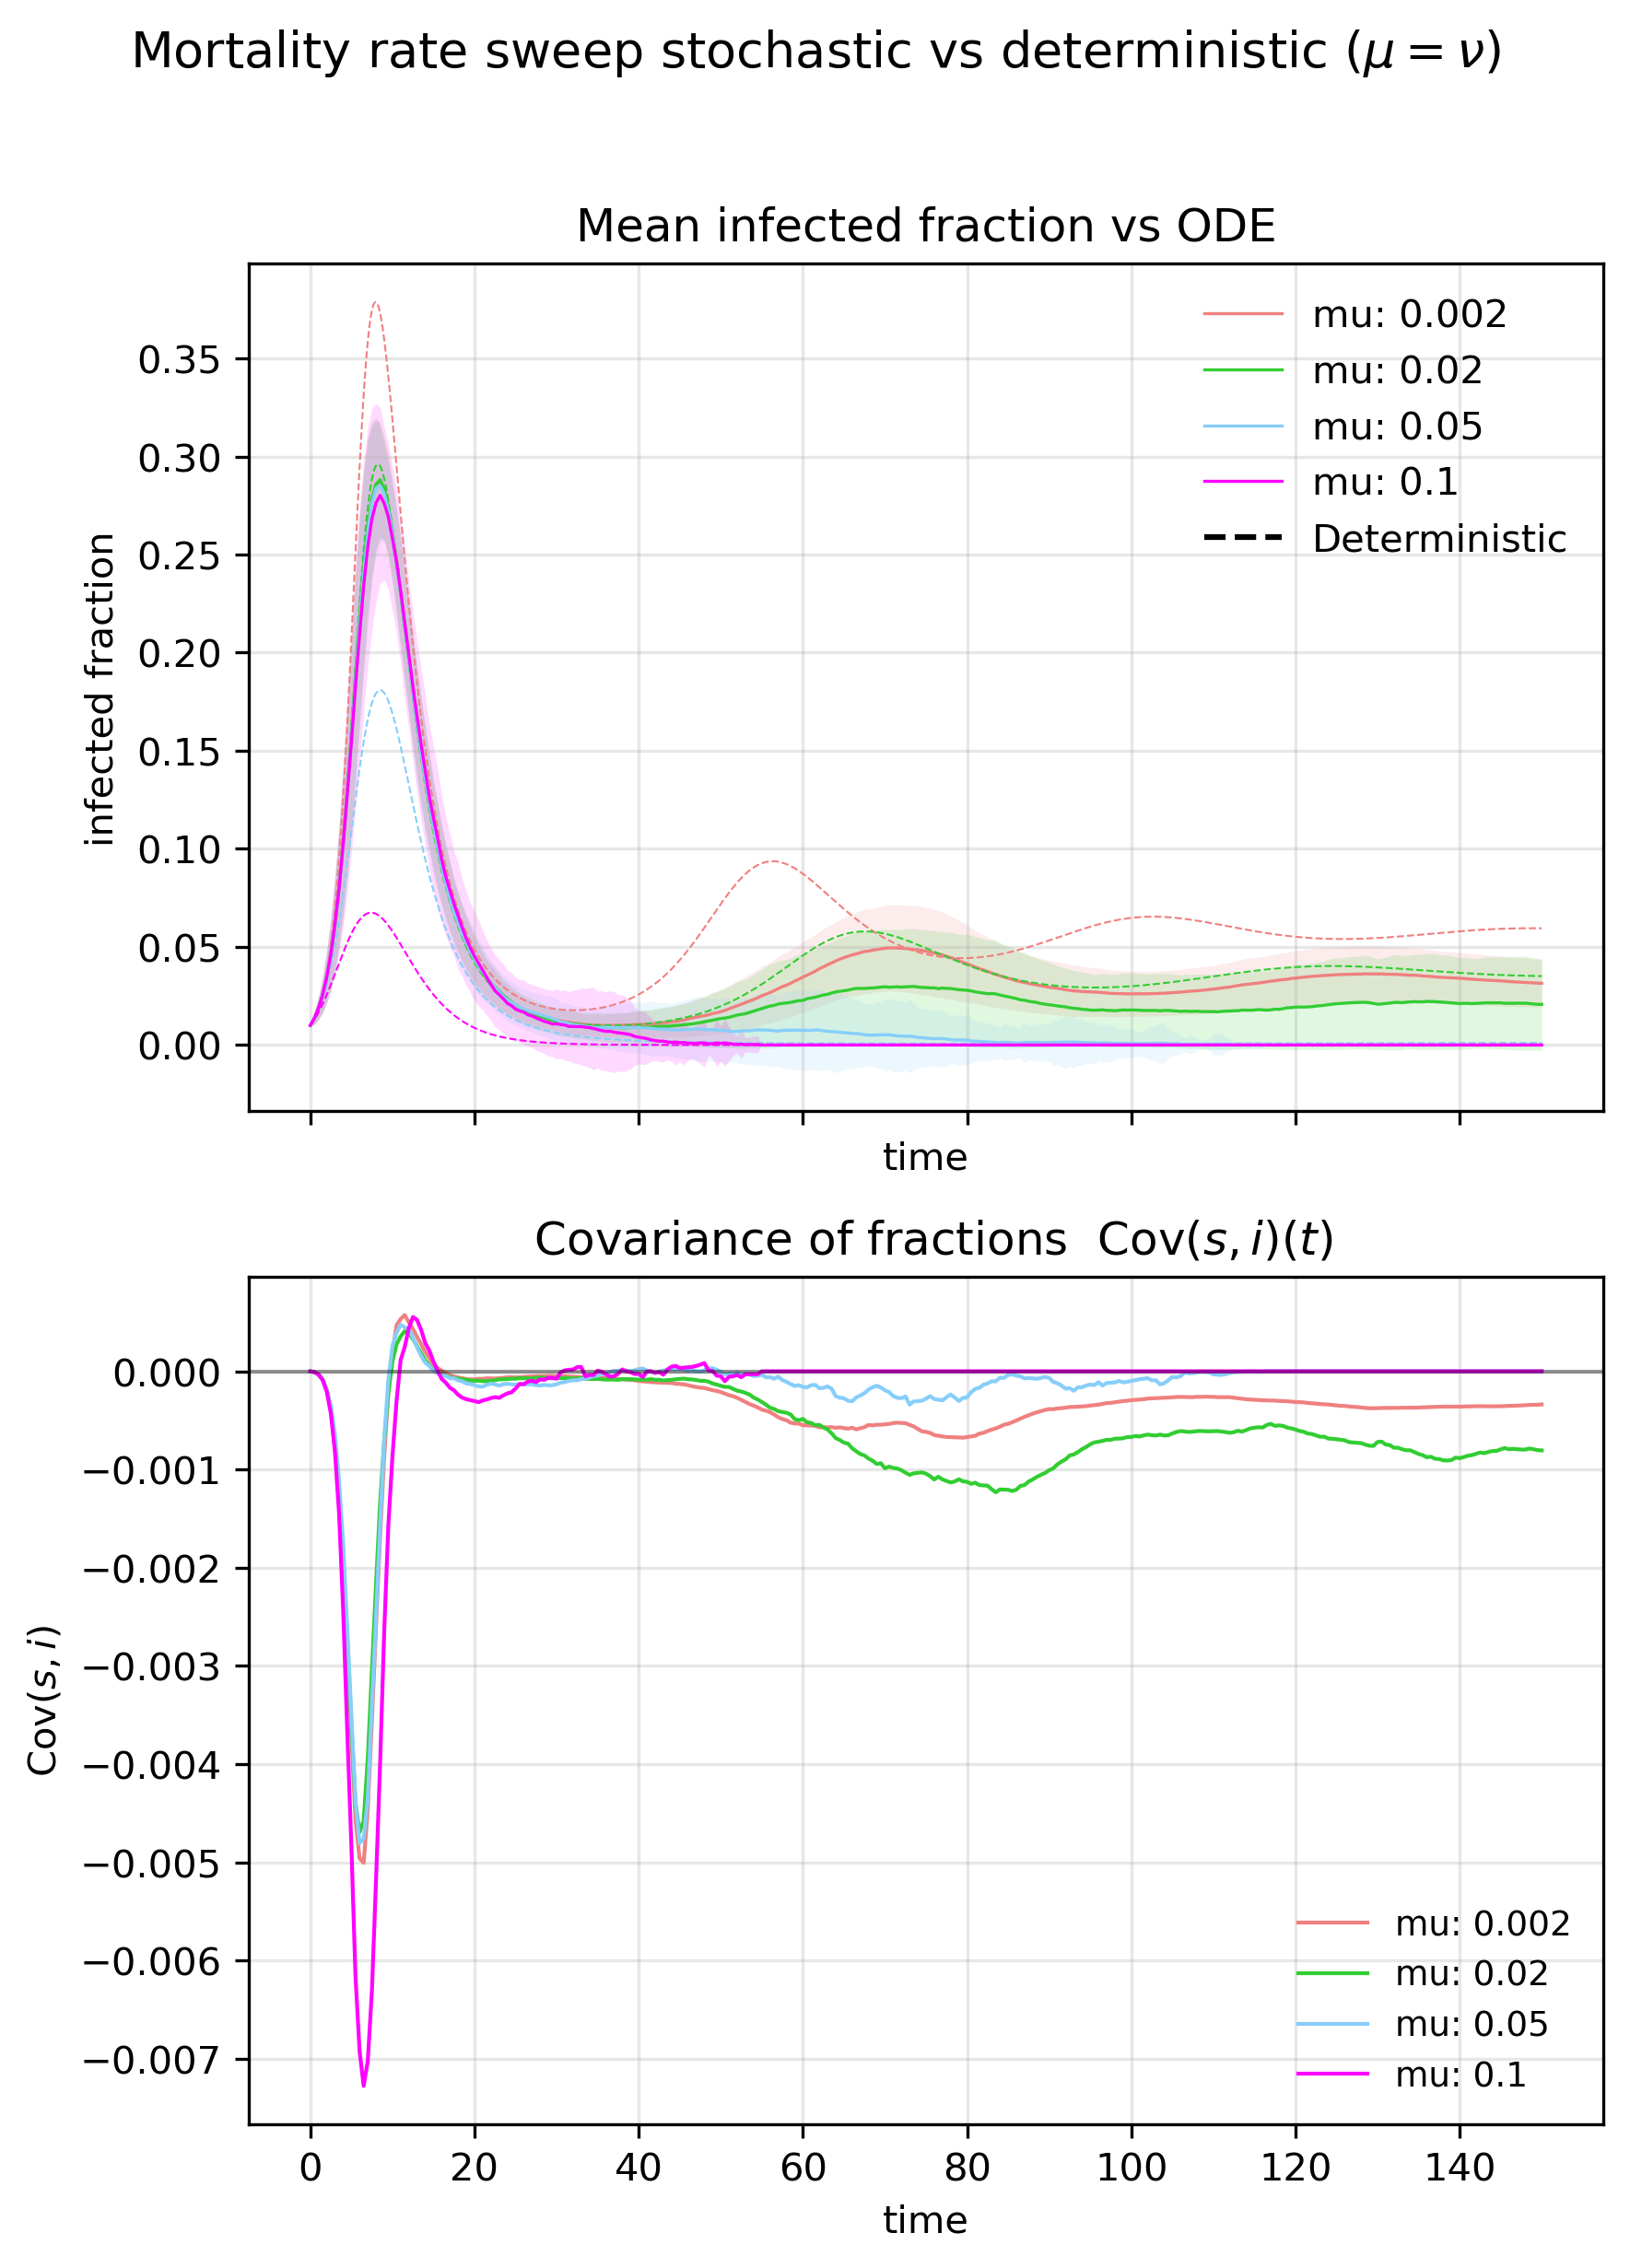

In [97]:
plot_sweep("mu", r"Mortality rate sweep stochastic vs deterministic ($\mu=\nu$)", mu_sweep)

In [ ]:
beta = 1
gamma = 1 / 3
mu = nu = 1 / 50
R_0 = beta / (mu + gamma)

# if mu << gamma T ~ 2pi*sqrt(AG)
A = 1 / mu * (R_0 - 1)
G = 1 / (mu + gamma)

natural_period = 2 * np.pi * np.sqrt(A * G)
